Московский Государственный Университет имени М.В. Ломоносова 

Факультет вычислительной математики и кибернетики 

Фоминская Галина

кафедра ММП, группа 317

2018


## Свёрточные автокодировщики для улучшения качества классификации изображений

В данной работе был проведен анализ задач классификации изображений с помощью свёрточной нейронной сети. Для реализации классов свёрточной нейронной сети и свёрточного автокодировщика использовалась библиотека pytorch. Эксперименты были проведены на датасетe stl-10. В качестве мер качества использовались accuracy и log loss. Также были рассмотрены решения задачи классификации изображений с использованием метода мультиномиальной регрессии и метода RandomForest, а также сравнение качества работы этих методов.


Подключение необходимых библиотек:

In [1]:
import conv
from importlib import reload
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import timeit
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
%matplotlib inline
reload(conv)

<module 'conv' from '/Users/Galya/Documents/studying/6th_semester/prac/task_1/conv.py'>

# Загрузка данных
В датасете stl-10 есть обучающая, тестовая и неразмеченная выборки. Обучающая выборка использовалась для тренировки моделей для классификации, а неразмеченная - для обучения автоэнкодера.

In [2]:
transform = transforms.Compose(
    [transforms.Resize(size=(32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.STL10(root='./data', split='train',
                                        download=False, transform=transform)

testset = torchvision.datasets.STL10(root='./data', split='test',
                                       download=False, transform=transform)

unlabeledset = torchvision.datasets.STL10(root='./data', split='unlabeled',
                                       download=False, transform=transform)

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

unlabeledloader = torch.utils.data.DataLoader(unlabeledset, batch_size=4,
                                          shuffle=True, num_workers=2)

## 1. Мультиномиальная регрессия и деревья

In [23]:
class Multinomial(nn.Module):
    def __init__(self, input_size=3 * 32 * 32):
        super(Multinomial, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 10)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.fc1(x)
        return x

In [24]:
mult = Multinomial()

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mult.parameters(), lr=0.001, weight_decay=10e-4)

In [26]:
for epoch in range(40):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = mult(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 1.968
[2,  1000] loss: 1.815
[3,  1000] loss: 1.741
[4,  1000] loss: 1.720
[5,  1000] loss: 1.673
[6,  1000] loss: 1.658
[7,  1000] loss: 1.631
[8,  1000] loss: 1.606
[9,  1000] loss: 1.578
[10,  1000] loss: 1.591
[11,  1000] loss: 1.561
[12,  1000] loss: 1.549
[13,  1000] loss: 1.535
[14,  1000] loss: 1.528
[15,  1000] loss: 1.525
[16,  1000] loss: 1.496
[17,  1000] loss: 1.496
[18,  1000] loss: 1.488
[19,  1000] loss: 1.478
[20,  1000] loss: 1.457
[21,  1000] loss: 1.460
[22,  1000] loss: 1.447
[23,  1000] loss: 1.438
[24,  1000] loss: 1.432
[25,  1000] loss: 1.427
[26,  1000] loss: 1.421
[27,  1000] loss: 1.415
[28,  1000] loss: 1.410
[29,  1000] loss: 1.396
[30,  1000] loss: 1.381
[31,  1000] loss: 1.381
[32,  1000] loss: 1.369
[33,  1000] loss: 1.364
[34,  1000] loss: 1.369
[35,  1000] loss: 1.351
[36,  1000] loss: 1.361
[37,  1000] loss: 1.357
[38,  1000] loss: 1.331
[39,  1000] loss: 1.343
[40,  1000] loss: 1.340
Finished Training


In [27]:
correct = 0
total = 0
running_loss = 0.0
for data in testloader:
    images, labels = data
    outputs = mult(Variable(images))
    loss = criterion(outputs, Variable(labels))
    running_loss += loss.data[0]
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 8000 test images: %d %%' % (
    100 * correct / total))
print('Log-loss of the network on the 8000 test images: ',
    running_loss / total)

Accuracy of the network on the 8000 test images: 36 %
Log-loss of the network on the 8000 test images:  0.45098293489590285


In [28]:
clf = RandomForestClassifier(max_depth=10, random_state=0)

X_train = []
y_train = []
for i, data in enumerate(trainloader, 0):
    X_tmp, y_tmp = data
    for elem in y_tmp:
        y_train.append(elem)

    tmp = np.array(X_tmp.view(4, 3 * 32 * 32))
    if type(X_train) is list:
        X_train = tmp
    else:
        X_train = np.vstack((X_train, tmp))

In [29]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [30]:
correct = 0
total = 0
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
for data in testloader:
    X_test, y_test = data
    X_test = X_test.view(-1, 3 * 32 * 32)
    outputs = clf.predict(np.array(X_test))
    total += y_test.size(0)
    correct += (outputs == y_test).sum()


print('Accuracy of the network on the 8000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 8000 test images: 34 %


Как видно, мультиномиальная регрессия дает на тестовых данных качество 36%, а алгоритм RandomForest 34%.

## 2. Сверточная нейронная сеть  

Посмотрим, какое качество классификации нам удастся получить, настраивая параметры сети.

Подберем размер ядра свёртки (небольшие значения, от 2 до 8)

In [31]:
criterion = nn.CrossEntropyLoss()

In [32]:
reload(conv)
from conv import ConvNet

In [42]:
losses = []


for conv1_kernel_size in range(2, 10, 2):
    loss_tmp = []
    print('Conv kernel size: ', conv1_kernel_size)
    net = ConvNet(conv1_kernel_size=conv1_kernel_size, \
                      conv1_out_channels=20, \
                      layers_num=1)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    start_time = timeit.default_timer()
    for epoch in range(30):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data

            inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]
            if i % 1000 == 999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                loss_tmp.append(running_loss)
                running_loss = 0.0
    losses.append(loss_tmp)
    print('Time: %d' % (timeit.default_timer() - start_time))
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    print('Accuracy of the network on the 80000 test images: %d %%' % (
                100 * correct / total))

Conv kernel size:  2
[1,  1000] loss: 2.063
[2,  1000] loss: 1.722
[3,  1000] loss: 1.548
[4,  1000] loss: 1.409
[5,  1000] loss: 1.289
[6,  1000] loss: 1.171
[7,  1000] loss: 1.074
[8,  1000] loss: 0.965
[9,  1000] loss: 0.864
[10,  1000] loss: 0.747
[11,  1000] loss: 0.627
[12,  1000] loss: 0.530
[13,  1000] loss: 0.409
[14,  1000] loss: 0.306
[15,  1000] loss: 0.235
[16,  1000] loss: 0.238
[17,  1000] loss: 0.179
[18,  1000] loss: 0.097
[19,  1000] loss: 0.070
[20,  1000] loss: 0.116
[21,  1000] loss: 0.083
[22,  1000] loss: 0.085
[23,  1000] loss: 0.054
[24,  1000] loss: 0.013
[25,  1000] loss: 0.017
[26,  1000] loss: 0.002
[27,  1000] loss: 0.002
[28,  1000] loss: 0.001
[29,  1000] loss: 0.001
[30,  1000] loss: 0.001
Time: 189
Accuracy of the network on the 80000 test images: 53 %
Conv kernel size:  4
[1,  1000] loss: 2.021
[2,  1000] loss: 1.641
[3,  1000] loss: 1.460
[4,  1000] loss: 1.325
[5,  1000] loss: 1.216
[6,  1000] loss: 1.119
[7,  1000] loss: 1.001
[8,  1000] loss: 0.90

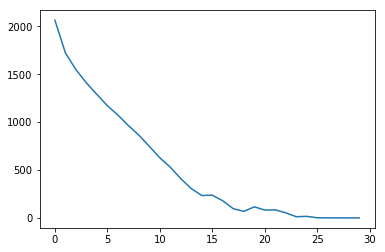

In [45]:
plt.plot(range(30), losses[1])
#plt.plot(range(30), losses[1])
#plt.plot(range(30), losses[2])
#plt.plot(range(30), losses[3])


\begin{table}[!h]
    \begin{center}
    \caption{kernel size}
    \begin{tabular}{|c|c|c|c|c|}
        \hline  \bf{kernel size} & \bf{time (s)}  & \bf{accuracy (\%)}  \\ \hline
        2 & 189  & \bf{53} \\ \hline
        4 & 175  & \bf{53} \\ \hline
        6 & 159 &  52 \\ \hline
        8 & \bf{152} &  49 \\ \hline
    \end{tabular}

    \label{kernelsize}
    \end{center}
\end{table}

Видно, что лучшее значение accuracy и лучшее время получается при размере ядра свертки 4.

Подберем количество фильтров на свёрточном слое (достаточно больше значения, от 5 до 40)

In [46]:
losses_channels = []

for conv1_out_channels in range(5, 45, 5):
    loss_tmp = []
    print('Conv out channels: ', conv1_out_channels)
    net = ConvNet(conv1_kernel_size=4, \
                      conv1_out_channels=conv1_out_channels, \
                      layers_num=1)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    start_time = timeit.default_timer()
    for epoch in range(30):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data

            inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]
            if i % 1000 == 999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                loss_tmp.append(running_loss)
                running_loss = 0.0
    losses_channels.append(loss_tmp)
    print('Time: %d' % (timeit.default_timer() - start_time))
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
    print('Accuracy of the network on the 80000 test images: %d %%' % (
                100 * correct / total))

Conv out channels:  5
[1,  1000] loss: 2.191
[2,  1000] loss: 1.768
[3,  1000] loss: 1.600
[4,  1000] loss: 1.472
[5,  1000] loss: 1.364
[6,  1000] loss: 1.287
[7,  1000] loss: 1.186
[8,  1000] loss: 1.108
[9,  1000] loss: 1.016
[10,  1000] loss: 0.922
[11,  1000] loss: 0.819
[12,  1000] loss: 0.743
[13,  1000] loss: 0.633
[14,  1000] loss: 0.586
[15,  1000] loss: 0.483
[16,  1000] loss: 0.406
[17,  1000] loss: 0.349
[18,  1000] loss: 0.291
[19,  1000] loss: 0.277
[20,  1000] loss: 0.210
[21,  1000] loss: 0.213
[22,  1000] loss: 0.156
[23,  1000] loss: 0.167
[24,  1000] loss: 0.127
[25,  1000] loss: 0.119
[26,  1000] loss: 0.131
[27,  1000] loss: 0.229
[28,  1000] loss: 0.109
[29,  1000] loss: 0.148
[30,  1000] loss: 0.065
Time: 93
Accuracy of the network on the 80000 test images: 46 %
Conv out channels:  10
[1,  1000] loss: 2.109
[2,  1000] loss: 1.719
[3,  1000] loss: 1.526
[4,  1000] loss: 1.412
[5,  1000] loss: 1.302
[6,  1000] loss: 1.198
[7,  1000] loss: 1.127
[8,  1000] loss: 0.

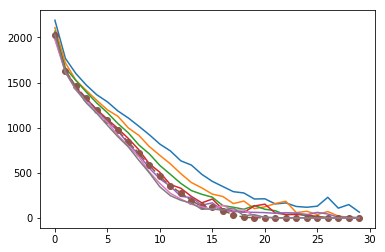

In [56]:
plt.plot(range(30), losses_channels[0])
plt.plot(range(30), losses_channels[1])
plt.plot(range(30), losses_channels[2])
plt.plot(range(30), losses_channels[3])
plt.plot(range(30), losses_channels[4])
plt.plot(range(30), losses_channels[5], 'o--')
plt.plot(range(30), losses_channels[6])
plt.plot(range(30), losses_channels[7])

Видно, что лучшее качество 55 % на тестовой выборке достигается у модели с 30 фильтрами на сверточном слое.

Попробуем проверить, улучшит ли качество добавление еще одного сверточного слоя

In [237]:
print('Number of layers: ', 2)
net = ConvNet(conv1_kernel_size=6, \
                  conv1_out_channels=40, \
                  layers_num=2)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

Number of layers:  2


In [241]:
optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay=1e-4)

In [242]:
start_time = timeit.default_timer()
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
print('Time: ', timeit.default_timer() - start_time)
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 80000 test images: %d %%' % (
                100 * correct / total))

[1,  1000] loss: 0.128
[2,  1000] loss: 0.043
[3,  1000] loss: 0.029
[4,  1000] loss: 0.022
[5,  1000] loss: 0.019
[6,  1000] loss: 0.016
[7,  1000] loss: 0.014
[8,  1000] loss: 0.014
[9,  1000] loss: 0.012
[10,  1000] loss: 0.011
[11,  1000] loss: 0.011
[12,  1000] loss: 0.009
[13,  1000] loss: 0.009
[14,  1000] loss: 0.008
[15,  1000] loss: 0.008
[16,  1000] loss: 0.007
[17,  1000] loss: 0.007
[18,  1000] loss: 0.006
[19,  1000] loss: 0.006
[20,  1000] loss: 0.006
[21,  1000] loss: 0.005
[22,  1000] loss: 0.006
[23,  1000] loss: 0.005
[24,  1000] loss: 0.005
[25,  1000] loss: 0.005
[26,  1000] loss: 0.005
[27,  1000] loss: 0.005
[28,  1000] loss: 0.004
[29,  1000] loss: 0.004
[30,  1000] loss: 0.004
[31,  1000] loss: 0.004
[32,  1000] loss: 0.004
[33,  1000] loss: 0.004
[34,  1000] loss: 0.004
[35,  1000] loss: 0.003
[36,  1000] loss: 0.003
[37,  1000] loss: 0.003
[38,  1000] loss: 0.003
[39,  1000] loss: 0.003
[40,  1000] loss: 0.003
[41,  1000] loss: 0.003
[42,  1000] loss: 0.003
[

Двухслойная сеть была обучена за 150 эпох и качество не превысило  41 %. Поэтому в дальнейшем использовалась однослойная сеть.

Подберем значение momentum для метода SGD. До этого использовалось значение momentum = 0.9.

In [247]:
net = ConvNet(conv1_kernel_size=6, \
                  conv1_out_channels=40, \
                  layers_num=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [248]:
start_time = timeit.default_timer()
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
print('Time: ', timeit.default_timer() - start_time)
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 80000 test images: %d %%' % (
                100 * correct / total))

[1,  1000] loss: 1.983
[2,  1000] loss: 1.598
[3,  1000] loss: 1.441
[4,  1000] loss: 1.319
[5,  1000] loss: 1.180
[6,  1000] loss: 1.081
[7,  1000] loss: 0.965
[8,  1000] loss: 0.835
[9,  1000] loss: 0.695
[10,  1000] loss: 0.606
[11,  1000] loss: 0.495
[12,  1000] loss: 0.360
[13,  1000] loss: 0.267
[14,  1000] loss: 0.222
[15,  1000] loss: 0.152
[16,  1000] loss: 0.168
[17,  1000] loss: 0.136
[18,  1000] loss: 0.188
[19,  1000] loss: 0.122
[20,  1000] loss: 0.080
[21,  1000] loss: 0.118
[22,  1000] loss: 0.119
[23,  1000] loss: 0.082
[24,  1000] loss: 0.040
[25,  1000] loss: 0.040
[26,  1000] loss: 0.086
[27,  1000] loss: 0.030
[28,  1000] loss: 0.004
[29,  1000] loss: 0.002
[30,  1000] loss: 0.001
[31,  1000] loss: 0.001
[32,  1000] loss: 0.001
[33,  1000] loss: 0.001
[34,  1000] loss: 0.001
[35,  1000] loss: 0.001
[36,  1000] loss: 0.001
[37,  1000] loss: 0.001
[38,  1000] loss: 0.000
[39,  1000] loss: 0.000
[40,  1000] loss: 0.000
[41,  1000] loss: 0.000
[42,  1000] loss: 0.000
[

In [249]:
net = ConvNet(conv1_kernel_size=6, \
                  conv1_out_channels=40, \
                  layers_num=1)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1, weight_decay=1e-4)

In [250]:
start_time = timeit.default_timer()
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
print('Time: ', timeit.default_timer() - start_time)
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 80000 test images: %d %%' % (
                100 * correct / total))

[1,  1000] loss: 2.287
[2,  1000] loss: 2.180
[3,  1000] loss: 1.982
[4,  1000] loss: 1.849
[5,  1000] loss: 1.757
[6,  1000] loss: 1.691
[7,  1000] loss: 1.633
[8,  1000] loss: 1.573
[9,  1000] loss: 1.539
[10,  1000] loss: 1.497
[11,  1000] loss: 1.441
[12,  1000] loss: 1.405
[13,  1000] loss: 1.370
[14,  1000] loss: 1.329
[15,  1000] loss: 1.287
[16,  1000] loss: 1.259
[17,  1000] loss: 1.221
[18,  1000] loss: 1.181
[19,  1000] loss: 1.146
[20,  1000] loss: 1.121
[21,  1000] loss: 1.082
[22,  1000] loss: 1.061
[23,  1000] loss: 1.026
[24,  1000] loss: 0.985
[25,  1000] loss: 0.943
[26,  1000] loss: 0.916
[27,  1000] loss: 0.883
[28,  1000] loss: 0.850
[29,  1000] loss: 0.816
[30,  1000] loss: 0.771
[31,  1000] loss: 0.735
[32,  1000] loss: 0.704
[33,  1000] loss: 0.669
[34,  1000] loss: 0.623
[35,  1000] loss: 0.581
[36,  1000] loss: 0.539
[37,  1000] loss: 0.497
[38,  1000] loss: 0.476
[39,  1000] loss: 0.414
[40,  1000] loss: 0.402
[41,  1000] loss: 0.360
[42,  1000] loss: 0.314
[

In [251]:
net = ConvNet(conv1_kernel_size=6, \
                  conv1_out_channels=40, \
                  layers_num=1)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [252]:
start_time = timeit.default_timer()
for epoch in range(40):
    running_loss = 0.0
    if epoch == 28:
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.0, weight_decay=1e-4)
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
print('Time: ', timeit.default_timer() - start_time)
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 80000 test images: %d %%' % (
                100 * correct / total))

[1,  1000] loss: 2.017
[2,  1000] loss: 1.613
[3,  1000] loss: 1.444
[4,  1000] loss: 1.337
[5,  1000] loss: 1.214
[6,  1000] loss: 1.080
[7,  1000] loss: 0.962
[8,  1000] loss: 0.867
[9,  1000] loss: 0.731
[10,  1000] loss: 0.570
[11,  1000] loss: 0.453
[12,  1000] loss: 0.378
[13,  1000] loss: 0.326
[14,  1000] loss: 0.221
[15,  1000] loss: 0.196
[16,  1000] loss: 0.144
[17,  1000] loss: 0.123
[18,  1000] loss: 0.106
[19,  1000] loss: 0.082
[20,  1000] loss: 0.129
[21,  1000] loss: 0.118
[22,  1000] loss: 0.084
[23,  1000] loss: 0.083
[24,  1000] loss: 0.026
[25,  1000] loss: 0.033
[26,  1000] loss: 0.065
[27,  1000] loss: 0.051
[28,  1000] loss: 0.048
[29,  1000] loss: 0.020
[30,  1000] loss: 0.005
[31,  1000] loss: 0.003
[32,  1000] loss: 0.003
[33,  1000] loss: 0.003
[34,  1000] loss: 0.003
[35,  1000] loss: 0.002
[36,  1000] loss: 0.002
[37,  1000] loss: 0.002
[38,  1000] loss: 0.002
[39,  1000] loss: 0.002
[40,  1000] loss: 0.002
Time:  372.5535196510027
Accuracy of the network 

(опционально) использования специальных методов оптимизации для нейросетей (Adam, Adagrad . . . )

In [31]:
net = ConvNet(conv1_kernel_size=2, \
                  conv1_out_channels=30, \
                  layers_num=1)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

In [32]:
start_time = timeit.default_timer()
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
print('Time: ', timeit.default_timer() - start_time)
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 80000 test images: %d %%' % (
                100 * correct / total))

[1,  1000] loss: 1.861
[2,  1000] loss: 1.509
[3,  1000] loss: 1.321
[4,  1000] loss: 1.193
[5,  1000] loss: 1.062
[6,  1000] loss: 0.952
[7,  1000] loss: 0.834
[8,  1000] loss: 0.722
[9,  1000] loss: 0.624
[10,  1000] loss: 0.546
[11,  1000] loss: 0.469
[12,  1000] loss: 0.413
[13,  1000] loss: 0.363
[14,  1000] loss: 0.248
[15,  1000] loss: 0.293
[16,  1000] loss: 0.222
[17,  1000] loss: 0.199
[18,  1000] loss: 0.203
[19,  1000] loss: 0.215
[20,  1000] loss: 0.144
[21,  1000] loss: 0.138
[22,  1000] loss: 0.167
[23,  1000] loss: 0.133
[24,  1000] loss: 0.147
[25,  1000] loss: 0.100
[26,  1000] loss: 0.145
[27,  1000] loss: 0.119
[28,  1000] loss: 0.117
[29,  1000] loss: 0.108
[30,  1000] loss: 0.110
Time:  1793.1189016990102
Accuracy of the network on the 80000 test images: 47 %


In [33]:
net = ConvNet(conv1_kernel_size=2, \
                  conv1_out_channels=30, \
                  layers_num=1)
optimizer = optim.Adagrad(net.parameters(), lr=0.001, weight_decay=1e-4)

In [34]:
start_time = timeit.default_timer()
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
print('Time: ', timeit.default_timer() - start_time)
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 80000 test images: %d %%' % (
                100 * correct / total))

[1,  1000] loss: 1.955
[2,  1000] loss: 1.760
[3,  1000] loss: 1.705
[4,  1000] loss: 1.647
[5,  1000] loss: 1.617
[6,  1000] loss: 1.592
[7,  1000] loss: 1.555
[8,  1000] loss: 1.542
[9,  1000] loss: 1.522
[10,  1000] loss: 1.500
[11,  1000] loss: 1.483
[12,  1000] loss: 1.476
[13,  1000] loss: 1.463
[14,  1000] loss: 1.452
[15,  1000] loss: 1.434
[16,  1000] loss: 1.426
[17,  1000] loss: 1.421
[18,  1000] loss: 1.401
[19,  1000] loss: 1.393
[20,  1000] loss: 1.376
[21,  1000] loss: 1.373
[22,  1000] loss: 1.366
[23,  1000] loss: 1.359
[24,  1000] loss: 1.348
[25,  1000] loss: 1.336
[26,  1000] loss: 1.336
[27,  1000] loss: 1.325
[28,  1000] loss: 1.326
[29,  1000] loss: 1.313
[30,  1000] loss: 1.309
Time:  866.1395086999983
Accuracy of the network on the 80000 test images: 48 %


the best set of parameters

In [57]:
net = ConvNet(conv1_kernel_size=4, \
                      conv1_out_channels=30, \
                      layers_num=1)

In [58]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [59]:
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [60]:
correct = 0
total = 0
running_loss = 0.0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    loss = criterion(outputs, Variable(labels))
    running_loss += loss.data[0]
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 8000 test images: %d %%' % (
    100 * correct / total))
print('Log-loss of the network on the 8000 test images: ',
    running_loss / total)

Accuracy of the network on the 8000 test images: 53 %
Log-loss of the network on the 8000 test images:  0.9153981669416044


## 3 Автоэнкодер

In [66]:
reload(conv)
from conv import ConvAutoEncoder

In [67]:
autoencoder = ConvAutoEncoder(conv_out_channels=30)
criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
print(autoencoder)

ConvAutoEncoder(
  (conv): Conv2d (3, 30, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
  (transpose): ConvTranspose2d (30, 3, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
)


In [69]:
for conv_out_channels in range(5, 45, 5):
    autoencoder = ConvAutoEncoder(conv_out_channels=conv_out_channels)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(autoencoder.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    print(autoencoder)
    for epoch in range(5):
        running_loss = 0.0
        print("Epoch %d" % epoch)

        for i, (images,_) in enumerate(unlabeledloader):    # Ignore image labels
            optimizer.zero_grad()
            out, code = autoencoder(Variable(images))

            loss = criterion(out, Variable(images))
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]

            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    total = 0.0
    counter = 0
    for data in trainloader:
        images, labels = data
        counter += 4
        outputs, _ = autoencoder(Variable(images))
        total += criterion(outputs, Variable(images)).data[0]
    print('Test loss = ', total / counter)

ConvAutoEncoder(
  (conv): Conv2d (3, 5, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
  (transpose): ConvTranspose2d (5, 3, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
)
Epoch 0
[1,  2000] loss: 0.164
[1,  4000] loss: 0.092
[1,  6000] loss: 0.072
[1,  8000] loss: 0.069
[1, 10000] loss: 0.067
[1, 12000] loss: 0.066
[1, 14000] loss: 0.065
[1, 16000] loss: 0.063
[1, 18000] loss: 0.061
[1, 20000] loss: 0.059
[1, 22000] loss: 0.058
[1, 24000] loss: 0.057
Epoch 1
[2,  2000] loss: 0.055
[2,  4000] loss: 0.054
[2,  6000] loss: 0.054
[2,  8000] loss: 0.053
[2, 10000] loss: 0.052
[2, 12000] loss: 0.052
[2, 14000] loss: 0.052
[2, 16000] loss: 0.051
[2, 18000] loss: 0.051
[2, 20000] loss: 0.051
[2, 22000] loss: 0.050
[2, 24000] loss: 0.050
Epoch 2
[3,  2000] loss: 0.049
[3,  4000] loss: 0.050
[3,  6000] loss: 0.050
[3,  8000] loss: 0.050
[3

[3, 16000] loss: 0.022
[3, 18000] loss: 0.022
[3, 20000] loss: 0.021
[3, 22000] loss: 0.021
[3, 24000] loss: 0.021
Epoch 3
[4,  2000] loss: 0.021
[4,  4000] loss: 0.021
[4,  6000] loss: 0.021
[4,  8000] loss: 0.021
[4, 10000] loss: 0.020
[4, 12000] loss: 0.020
[4, 14000] loss: 0.020
[4, 16000] loss: 0.020
[4, 18000] loss: 0.020
[4, 20000] loss: 0.020
[4, 22000] loss: 0.020
[4, 24000] loss: 0.020
Epoch 4
[5,  2000] loss: 0.020
[5,  4000] loss: 0.020
[5,  6000] loss: 0.020
[5,  8000] loss: 0.019
[5, 10000] loss: 0.020
[5, 12000] loss: 0.019
[5, 14000] loss: 0.019
[5, 16000] loss: 0.019
[5, 18000] loss: 0.019
[5, 20000] loss: 0.019
[5, 22000] loss: 0.019
[5, 24000] loss: 0.019
Test loss =  0.00486219621244818
ConvAutoEncoder(
  (conv): Conv2d (3, 30, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
  (transpose): ConvTranspose2d (30, 3, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (unpool): MaxUnpool2d(kerne

видно что при значениях числа фильтров на сверточном слое от 25 до 40 итоговый MSE на отложенной выборке не сильно меняется 

попробуем добиться улучшения засчет настройки padding

In [73]:
for padding in range(5):
    autoencoder = ConvAutoEncoder(conv_out_channels=40, conv_padding=padding, conv_kernel_size=2 * (padding + 1))
    criterion = nn.MSELoss()
    optimizer = optim.SGD(autoencoder.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    print(autoencoder)
    for epoch in range(5):
        running_loss = 0.0
        print("Epoch %d" % epoch)

        for i, (images,_) in enumerate(unlabeledloader):    # Ignore image labels
            optimizer.zero_grad()
            out, code = autoencoder(Variable(images))

            loss = criterion(out, Variable(images))
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]

            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    total = 0.0
    counter = 0
    for data in trainloader:
        images, labels = data
        counter += 4
        outputs, _ = autoencoder(Variable(images))
        total += criterion(outputs, Variable(images)).data[0]
    print('Test loss = ', total / counter)

ConvAutoEncoder(
  (conv): Conv2d (3, 40, kernel_size=(2, 2), stride=(2, 2))
  (transpose): ConvTranspose2d (40, 3, kernel_size=(2, 2), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
)
Epoch 0
[1,  2000] loss: 0.118
[1,  4000] loss: 0.074
[1,  6000] loss: 0.068
[1,  8000] loss: 0.064
[1, 10000] loss: 0.059
[1, 12000] loss: 0.055
[1, 14000] loss: 0.052
[1, 16000] loss: 0.050
[1, 18000] loss: 0.048
[1, 20000] loss: 0.047
[1, 22000] loss: 0.045
[1, 24000] loss: 0.044
Epoch 1
[2,  2000] loss: 0.043
[2,  4000] loss: 0.043
[2,  6000] loss: 0.041
[2,  8000] loss: 0.040
[2, 10000] loss: 0.040
[2, 12000] loss: 0.039
[2, 14000] loss: 0.039
[2, 16000] loss: 0.038
[2, 18000] loss: 0.037
[2, 20000] loss: 0.037
[2, 22000] loss: 0.037
[2, 24000] loss: 0.037
Epoch 2
[3,  2000] loss: 0.036
[3,  4000] loss: 0.035
[3,  6000] loss: 0.035
[3,  8000] loss: 0.035
[3, 10000] loss: 0.035
[3, 12000

[3, 18000] loss: 0.012
[3, 20000] loss: 0.011
[3, 22000] loss: 0.011
[3, 24000] loss: 0.011
Epoch 3
[4,  2000] loss: 0.011
[4,  4000] loss: 0.011
[4,  6000] loss: 0.011
[4,  8000] loss: 0.011
[4, 10000] loss: 0.011
[4, 12000] loss: 0.011
[4, 14000] loss: 0.011
[4, 16000] loss: 0.011
[4, 18000] loss: 0.010
[4, 20000] loss: 0.010
[4, 22000] loss: 0.010
[4, 24000] loss: 0.010
Epoch 4
[5,  2000] loss: 0.010
[5,  4000] loss: 0.010
[5,  6000] loss: 0.010
[5,  8000] loss: 0.010
[5, 10000] loss: 0.010
[5, 12000] loss: 0.010
[5, 14000] loss: 0.010
[5, 16000] loss: 0.010
[5, 18000] loss: 0.010
[5, 20000] loss: 0.010
[5, 22000] loss: 0.010
[5, 24000] loss: 0.010
Test loss =  0.0023080769794527442


In [74]:
autoencoder = ConvAutoEncoder(conv_out_channels=40, conv_padding=3, conv_kernel_size=2 * (3 + 1))
criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
print(autoencoder)

ConvAutoEncoder(
  (conv): Conv2d (3, 40, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (transpose): ConvTranspose2d (40, 3, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
)


In [75]:
for epoch in range(10):
    running_loss = 0.0
    print("Epoch %d" % epoch)

    for i, (images,_) in enumerate(unlabeledloader):    # Ignore image labels
        optimizer.zero_grad()
        out, code = autoencoder(Variable(images))

        loss = criterion(out, Variable(images))
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


Epoch 0
[1,  2000] loss: 0.065
[1,  4000] loss: 0.033
[1,  6000] loss: 0.027
[1,  8000] loss: 0.023
[1, 10000] loss: 0.021
[1, 12000] loss: 0.020
[1, 14000] loss: 0.019
[1, 16000] loss: 0.018
[1, 18000] loss: 0.017
[1, 20000] loss: 0.016
[1, 22000] loss: 0.016
[1, 24000] loss: 0.015
Epoch 1
[2,  2000] loss: 0.015
[2,  4000] loss: 0.014
[2,  6000] loss: 0.014
[2,  8000] loss: 0.014
[2, 10000] loss: 0.014
[2, 12000] loss: 0.013
[2, 14000] loss: 0.013
[2, 16000] loss: 0.013
[2, 18000] loss: 0.013
[2, 20000] loss: 0.013
[2, 22000] loss: 0.012
[2, 24000] loss: 0.012
Epoch 2
[3,  2000] loss: 0.012
[3,  4000] loss: 0.012
[3,  6000] loss: 0.012
[3,  8000] loss: 0.012
[3, 10000] loss: 0.012
[3, 12000] loss: 0.011
[3, 14000] loss: 0.011
[3, 16000] loss: 0.011
[3, 18000] loss: 0.011
[3, 20000] loss: 0.011
[3, 22000] loss: 0.011
[3, 24000] loss: 0.011
Epoch 3
[4,  2000] loss: 0.011
[4,  4000] loss: 0.011
[4,  6000] loss: 0.011
[4,  8000] loss: 0.010
[4, 10000] loss: 0.010
[4, 12000] loss: 0.010
[4

In [76]:
total = 0.0
counter = 0
for data in trainloader:
    images, labels = data
    counter += 4
    outputs, _ = autoencoder(Variable(images))
    total += criterion(outputs, Variable(images)).data[0]
print('Test loss = ', total / counter)

Test loss =  0.0019220161563251168


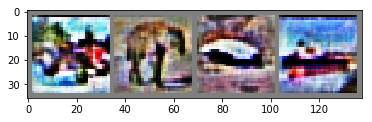

In [145]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(unlabeledloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(autoencoder(Variable(images))[0].data))
plt.savefig('new2.pdf', bbox_inches='tight')

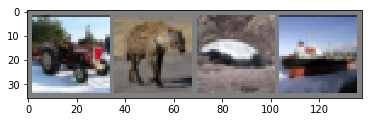

In [146]:
imshow(torchvision.utils.make_grid(images))
plt.savefig('old2.pdf', bbox_inches='tight')

## 4 Используем признаки из автоэнкодера

In [77]:
class Multinomial(nn.Module):
    def __init__(self, input_size=3 * 32 * 32):
        super(Multinomial, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 10)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.fc1(x)
        return x

In [85]:
mult = Multinomial(input_size=9000)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mult.parameters(), momentum=0.9, lr=0.001, weight_decay=10e-4)

In [86]:
optimizer = optim.SGD(mult.parameters(), momentum=0.0, lr=0.001, weight_decay=10e-4)

In [87]:
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        images, labels = data
        _, code = autoencoder.forward(x=Variable(images))
        tmp = code.data.view(4, -1)
        
        # wrap them in Variable
        inputs, labels = Variable(tmp), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mult(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 1.954
[2,  1000] loss: 1.633
[3,  1000] loss: 1.508
[4,  1000] loss: 1.411
[5,  1000] loss: 1.353
[6,  1000] loss: 1.300
[7,  1000] loss: 1.242
[8,  1000] loss: 1.195
[9,  1000] loss: 1.151
[10,  1000] loss: 1.111
[11,  1000] loss: 1.089
[12,  1000] loss: 1.050
[13,  1000] loss: 1.023
[14,  1000] loss: 0.993
[15,  1000] loss: 0.967
[16,  1000] loss: 0.946
[17,  1000] loss: 0.932
[18,  1000] loss: 0.900
[19,  1000] loss: 0.885
[20,  1000] loss: 0.856
[21,  1000] loss: 0.845
[22,  1000] loss: 0.830
[23,  1000] loss: 0.814
[24,  1000] loss: 0.792
[25,  1000] loss: 0.784
[26,  1000] loss: 0.770
[27,  1000] loss: 0.754
[28,  1000] loss: 0.752
[29,  1000] loss: 0.735
[30,  1000] loss: 0.711
[31,  1000] loss: 0.695
[32,  1000] loss: 0.692
[33,  1000] loss: 0.680
[34,  1000] loss: 0.668
[35,  1000] loss: 0.651
[36,  1000] loss: 0.648
[37,  1000] loss: 0.637
[38,  1000] loss: 0.622
[39,  1000] loss: 0.609
[40,  1000] loss: 0.603
[41,  1000] loss: 0.600
[42,  1000] loss: 0.585
[

In [88]:
correct = 0
total = 0
running_loss = 0.0
for data in testloader:
    images, labels = data
    _, code = autoencoder.forward(x=Variable(images))
    tmp = code.data.view(4, -1)
        
    outputs = mult(Variable(tmp))
    
    loss = criterion(outputs, Variable(labels))
    running_loss += loss.data[0]
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 8000 test images: %d %%' % (
    100 * correct / total))
print('Log-loss of the network on the 8000 test images: ',
    running_loss / total)

Accuracy of the network on the 8000 test images: 51 %
Log-loss of the network on the 8000 test images:  0.37072302227746695


Видим, что засчет использования признаков, выделенных автокодировщиком, качество работы мультиномиальной регрессии улучшилось

In [89]:
X_train = []
y_train = []
for i, data in enumerate(trainloader, 0):
    X_tmp, y_tmp = data
    for elem in y_tmp:
        y_train.append(elem)
 
    _, code = autoencoder.forward(x=Variable(X_tmp))
    
    tmp = np.array(code.data.view(4, -1))
    if type(X_train) is list:
        X_train = tmp
    else:
        X_train = np.vstack((X_train, tmp))

In [91]:
correct = 0
total = 0
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
for data in testloader:
    X_test, y_test = data
    
    _, code = autoencoder.forward(x=Variable(X_test))
    
    tmp = np.array(code.data.view(4, -1))
    
    outputs = clf.predict(tmp)
    total += y_test.size(0)
    correct += (outputs == y_test).sum()


print('Accuracy of the network on the 8000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 8000 test images: 36 %


Качество работы алгоритма RandomForest не изменилось. Это объясняется тем, что

## 5 Используем признаки из автоэнкодера для инициализации сети

In [97]:
reload(conv)


<module 'conv' from '/Users/Galya/Documents/studying/6th_semester/prac/task_1/conv.py'>

In [105]:
net = conv.ConvNet(conv1_kernel_size=8, \
                   conv1_padding=0, \
                         weight=autoencoder.conv.weight, \
                      conv1_out_channels=40, \
                      layers_num=1)

In [106]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [107]:
for epoch in range(30):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
    
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

[1,  1000] loss: 1.747
[2,  1000] loss: 1.374
[3,  1000] loss: 1.184
[4,  1000] loss: 1.056
[5,  1000] loss: 0.900
[6,  1000] loss: 0.748
[7,  1000] loss: 0.625
[8,  1000] loss: 0.510
[9,  1000] loss: 0.427
[10,  1000] loss: 0.305
[11,  1000] loss: 0.239
[12,  1000] loss: 0.150
[13,  1000] loss: 0.163
[14,  1000] loss: 0.197
[15,  1000] loss: 0.150
[16,  1000] loss: 0.174
[17,  1000] loss: 0.133
[18,  1000] loss: 0.116
[19,  1000] loss: 0.059
[20,  1000] loss: 0.043
[21,  1000] loss: 0.063
[22,  1000] loss: 0.008
[23,  1000] loss: 0.002
[24,  1000] loss: 0.001
[25,  1000] loss: 0.001
[26,  1000] loss: 0.001
[27,  1000] loss: 0.001
[28,  1000] loss: 0.001
[29,  1000] loss: 0.001
[30,  1000] loss: 0.001


In [109]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
    
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

[1,  1000] loss: 0.001
[2,  1000] loss: 0.001
[3,  1000] loss: 0.000
[4,  1000] loss: 0.000
[5,  1000] loss: 0.000


In [110]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the network on the 80000 test images: %d %%' % (
            100 * correct / total))

Accuracy of the network on the 80000 test images: 54 %


Не сильно улучшилось

In [112]:
reload(conv)
from conv import ConvAutoEncoder

In [113]:
autoencoder_for_net = ConvAutoEncoder(conv_out_channels=30, conv_padding=1, conv_kernel_size=2 * (1 + 1))
criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder_for_net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
print(autoencoder_for_net)

ConvAutoEncoder(
  (conv): Conv2d (3, 30, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (transpose): ConvTranspose2d (30, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
)


In [114]:
for epoch in range(5):
    running_loss = 0.0
    print("Epoch %d" % epoch)

    for i, (images,_) in enumerate(unlabeledloader):    # Ignore image labels
        optimizer.zero_grad()
        out, code = autoencoder_for_net(Variable(images))

        loss = criterion(out, Variable(images))
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


Epoch 0
[1,  2000] loss: 0.082
[1,  4000] loss: 0.051
[1,  6000] loss: 0.039
[1,  8000] loss: 0.033
[1, 10000] loss: 0.029
[1, 12000] loss: 0.027
[1, 14000] loss: 0.025
[1, 16000] loss: 0.024
[1, 18000] loss: 0.022
[1, 20000] loss: 0.021
[1, 22000] loss: 0.020
[1, 24000] loss: 0.020
Epoch 1
[2,  2000] loss: 0.019
[2,  4000] loss: 0.018
[2,  6000] loss: 0.018
[2,  8000] loss: 0.017
[2, 10000] loss: 0.017
[2, 12000] loss: 0.017
[2, 14000] loss: 0.016
[2, 16000] loss: 0.016
[2, 18000] loss: 0.016
[2, 20000] loss: 0.015
[2, 22000] loss: 0.015
[2, 24000] loss: 0.015
Epoch 2
[3,  2000] loss: 0.015
[3,  4000] loss: 0.015
[3,  6000] loss: 0.014
[3,  8000] loss: 0.014
[3, 10000] loss: 0.014
[3, 12000] loss: 0.014
[3, 14000] loss: 0.014
[3, 16000] loss: 0.014
[3, 18000] loss: 0.014
[3, 20000] loss: 0.013
[3, 22000] loss: 0.013
[3, 24000] loss: 0.013
Epoch 3
[4,  2000] loss: 0.013
[4,  4000] loss: 0.013
[4,  6000] loss: 0.013
[4,  8000] loss: 0.013
[4, 10000] loss: 0.013
[4, 12000] loss: 0.012
[4

In [115]:
total = 0.0
counter = 0
for data in trainloader:
    images, labels = data
    counter += 4
    outputs, _ = autoencoder_for_net(Variable(images))
    total += criterion(outputs, Variable(images)).data[0]
print('Test loss = ', total / counter)

Test loss =  0.002748841746058315


In [117]:
reload(conv)
from conv import ConvNet

In [118]:
net = ConvNet(conv1_kernel_size=4, \
                  conv1_out_channels=30, \
                  weight=autoencoder_for_net.conv.weight, \
                  layers_num=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [119]:
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0


[1,  1000] loss: 1.899
[2,  1000] loss: 1.507
[3,  1000] loss: 1.338
[4,  1000] loss: 1.182
[5,  1000] loss: 1.032
[6,  1000] loss: 0.886
[7,  1000] loss: 0.754
[8,  1000] loss: 0.621
[9,  1000] loss: 0.490
[10,  1000] loss: 0.346
[11,  1000] loss: 0.263
[12,  1000] loss: 0.209
[13,  1000] loss: 0.152
[14,  1000] loss: 0.087
[15,  1000] loss: 0.122
[16,  1000] loss: 0.062
[17,  1000] loss: 0.063
[18,  1000] loss: 0.040
[19,  1000] loss: 0.063
[20,  1000] loss: 0.061
[21,  1000] loss: 0.069
[22,  1000] loss: 0.065
[23,  1000] loss: 0.008
[24,  1000] loss: 0.002
[25,  1000] loss: 0.001
[26,  1000] loss: 0.001
[27,  1000] loss: 0.001
[28,  1000] loss: 0.001
[29,  1000] loss: 0.001
[30,  1000] loss: 0.001


In [120]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 80000 test images: %d %%' % (
            100 * correct / total))

Accuracy of the network on the 80000 test images: 55 %


Попробуем сделать больше итераций

In [121]:
reload(conv)
from conv import ConvAutoEncoder

In [129]:
autoencoder_for_net = ConvAutoEncoder(conv_out_channels=30, conv_padding=1, conv_kernel_size=2 * (1 + 1))
criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder_for_net.parameters(), lr=0.001, momentum=0.99, weight_decay=1e-4)
print(autoencoder_for_net)

ConvAutoEncoder(
  (conv): Conv2d (3, 30, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (transpose): ConvTranspose2d (30, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
)


In [130]:
for epoch in range(3):
    running_loss = 0.0
    print("Epoch %d" % epoch)

    for i, (images,_) in enumerate(unlabeledloader):    # Ignore image labels
        optimizer.zero_grad()
        out, code = autoencoder_for_net(Variable(images))

        loss = criterion(out, Variable(images))
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0



Epoch 0
[1,  2000] loss: 0.041
[1,  4000] loss: 0.018
[1,  6000] loss: 0.014
[1,  8000] loss: 0.013
[1, 10000] loss: 0.012
[1, 12000] loss: 0.011
[1, 14000] loss: 0.011
[1, 16000] loss: 0.010
[1, 18000] loss: 0.010
[1, 20000] loss: 0.010
[1, 22000] loss: 0.010
[1, 24000] loss: 0.009
Epoch 1
[2,  2000] loss: 0.009
[2,  4000] loss: 0.009
[2,  6000] loss: 0.009
[2,  8000] loss: 0.009
[2, 10000] loss: 0.009
[2, 12000] loss: 0.009
[2, 14000] loss: 0.009
[2, 16000] loss: 0.008
[2, 18000] loss: 0.008
[2, 20000] loss: 0.008
[2, 22000] loss: 0.008
[2, 24000] loss: 0.008
Epoch 2
[3,  2000] loss: 0.008
[3,  4000] loss: 0.008
[3,  6000] loss: 0.008
[3,  8000] loss: 0.008
[3, 10000] loss: 0.008
[3, 12000] loss: 0.008
[3, 14000] loss: 0.008
[3, 16000] loss: 0.008
[3, 18000] loss: 0.008
[3, 20000] loss: 0.008
[3, 22000] loss: 0.008
[3, 24000] loss: 0.008


In [131]:
total = 0.0
counter = 0
for data in trainloader:
    images, labels = data
    counter += 4
    outputs, _ = autoencoder_for_net(Variable(images))
    total += criterion(outputs, Variable(images)).data[0]
print('Test loss = ', total / counter)

Test loss =  0.0019469866850879043


In [147]:
reload(conv)
from conv import ConvNet

In [148]:
net = ConvNet(conv1_kernel_size=4, \
                  conv1_out_channels=30, \
                  weight=autoencoder_for_net.conv.weight, \
                  layers_num=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [149]:
for epoch in range(25):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0


[1,  1000] loss: 1.897
[2,  1000] loss: 1.532
[3,  1000] loss: 1.336
[4,  1000] loss: 1.190
[5,  1000] loss: 1.018
[6,  1000] loss: 0.884
[7,  1000] loss: 0.734
[8,  1000] loss: 0.590
[9,  1000] loss: 0.453
[10,  1000] loss: 0.343
[11,  1000] loss: 0.237
[12,  1000] loss: 0.151
[13,  1000] loss: 0.106
[14,  1000] loss: 0.088
[15,  1000] loss: 0.057
[16,  1000] loss: 0.086
[17,  1000] loss: 0.043
[18,  1000] loss: 0.065
[19,  1000] loss: 0.094
[20,  1000] loss: 0.032
[21,  1000] loss: 0.024
[22,  1000] loss: 0.034
[23,  1000] loss: 0.024
[24,  1000] loss: 0.011
[25,  1000] loss: 0.003


In [155]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.0, weight_decay=1e-4)

In [174]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

[1,  1000] loss: 0.001


In [175]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 80000 test images: %d %%' % (
            100 * correct / total))

Accuracy of the network on the 80000 test images: 55 %
